In [1]:
import sqlite3 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn=sqlite3.connect('database.sqlite')

In [3]:
matches_df=pd.read_sql("""
SELECT
Match.id, Country.name AS country_name, League.name AS league_name,
season,
date,
HT.team_long_name AS home_team,
AT.team_long_name AS away_team,
home_team_goal, away_team_goal
FROM Match
JOIN Country on Country.id=Match.country_id
JOIN League on League.id = Match.league_id
LEFT JOIN Team as HT on HT.team_api_id = Match.home_team_api_id
LEFT JOIN Team as AT on AT.team_api_id = Match.away_team_api_id
;""", conn)

In [4]:
def rates(hometeam, awayteam, data):
    goals_h=data[(data.home_team==hometeam)&(data.away_team==awayteam)]['home_team_goal'].sum()+data[(data.home_team==awayteam)&(data.away_team==hometeam)]['away_team_goal'].sum()
    goals_a=data[(data.home_team==hometeam)&(data.away_team==awayteam)]['away_team_goal'].sum()+data[(data.home_team==awayteam)&(data.away_team==hometeam)]['home_team_goal'].sum()
    no_games=data[((data.home_team==hometeam)&(data.away_team==awayteam))|((data.home_team==awayteam)&(data.away_team==hometeam))].shape[0]
    #backup for when no data available
    if no_games==0:
        rates= [data.home_team_goal.sum()/data.shape[0],data.away_team_goal.sum()/data.shape[0]]
    else:
        rates= [goals_h/no_games,goals_a/no_games]
    return rates

In [5]:
def gillespie(hometeam,awayteam,data,rseed=None):
    score=[0,0]
    t_rates=rates(hometeam,awayteam,data)
    if rseed is not None:
        np.random.set_state(rseed)
    t=0
    while t<1:
        dt=np.random.exponential(scale=1/sum(t_rates))
        whoscored=np.random.choice([0,1],p=t_rates/sum(t_rates))
        score[whoscored]+=1
        t+=dt
    return score

In [6]:
pred_season=pd.read_csv("season-1617_csv.csv")

In [7]:
fixtures=pred_season[['Date','HomeTeam','AwayTeam']]

In [8]:
def simulate_season(fixtures,train_data,num_sims=1):
    simulations=[]
    for i in range(num_sims):
        #copy fixture list as base of simulated season data frame
        sim_season=fixtures.copy()
    
        #simulate the results in the fixture list and create results, goals, win/draw cols
        sim_season['result']=sim_season.apply(lambda row: gillespie(row.HomeTeam,row.AwayTeam,matches_df),axis=1)
        sim_season['home_team_goal']=sim_season.apply(lambda row: row.result[0],axis=1)
        sim_season['away_team_goal']=sim_season.apply(lambda row: row.result[1],axis=1)
        sim_season['home_win']=sim_season.home_team_goal>sim_season.away_team_goal
        sim_season['away_win']=sim_season.home_team_goal<sim_season.away_team_goal
        sim_season['draw']=sim_season.home_team_goal==sim_season.away_team_goal
    
        #convert fixtures & results into league table. First Home/Away Tables and then Overall
        sim_league_table=pd.DataFrame(pd.unique(sim_season.HomeTeam),columns=['Team'])
        sim_league_table['GF_Home']=sim_league_table.apply(lambda row: sim_season[sim_season.HomeTeam==row.Team].home_team_goal.sum(),axis=1)
        sim_league_table['GA_Home']=sim_league_table.apply(lambda row: sim_season[sim_season.HomeTeam==row.Team].away_team_goal.sum(),axis=1)
        sim_league_table['W_Home']=sim_league_table.apply(lambda row: sim_season[sim_season.HomeTeam==row.Team].home_win.sum(),axis=1)
        sim_league_table['D_Home']=sim_league_table.apply(lambda row: sim_season[sim_season.HomeTeam==row.Team].draw.sum(),axis=1)
        sim_league_table['L_Home']=sim_league_table.apply(lambda row: sim_season[sim_season.HomeTeam==row.Team].away_win.sum(),axis=1)
        sim_league_table['GD_Home']=sim_league_table['GF_Home']-sim_league_table['GA_Home']
        sim_league_table['Pts_Home']=3*sim_league_table['W_Home']+sim_league_table['D_Home']

        sim_league_table['GF_Away']=sim_league_table.apply(lambda row: sim_season[sim_season.AwayTeam==row.Team].away_team_goal.sum(),axis=1)
        sim_league_table['GA_Away']=sim_league_table.apply(lambda row: sim_season[sim_season.AwayTeam==row.Team].home_team_goal.sum(),axis=1)
        sim_league_table['W_Away']=sim_league_table.apply(lambda row: sim_season[sim_season.AwayTeam==row.Team].away_win.sum(),axis=1)
        sim_league_table['D_Away']=sim_league_table.apply(lambda row: sim_season[sim_season.AwayTeam==row.Team].draw.sum(),axis=1)
        sim_league_table['L_Away']=sim_league_table.apply(lambda row: sim_season[sim_season.AwayTeam==row.Team].home_win.sum(),axis=1)
        sim_league_table['GD_Away']=sim_league_table['GF_Away']-sim_league_table['GA_Away']
        sim_league_table['Pts_Away']=3*sim_league_table['W_Away']+sim_league_table['D_Away']

        sim_league_table['W']=sim_league_table['W_Home']+sim_league_table['W_Away']
        sim_league_table['D']=sim_league_table['D_Home']+sim_league_table['D_Away']
        sim_league_table['L']=sim_league_table['L_Home']+sim_league_table['L_Away']
        sim_league_table['GF']=sim_league_table['GF_Home']+sim_league_table['GF_Away']
        sim_league_table['GA']=sim_league_table['GA_Home']+sim_league_table['GA_Away']
        sim_league_table['GD']=sim_league_table['GD_Home']+sim_league_table['GD_Away']
        sim_league_table['Pts']=sim_league_table['Pts_Home']+sim_league_table['Pts_Away']
        
        sim_league_table.sort_values(by=['Pts','GD','GF'],ascending=False)
        
        #save vals in dictionary
        simulations.append({'fix_and_res':sim_season,'league_table':sim_league_table})
    return simulations

In [9]:
N=50
sims=simulate_season(fixtures,matches_df,num_sims=N)

In [12]:
def average_results(sim):
    teams=pd.unique(sim[0]['league_table'].Team)
    num_sims=len(sim)
    cum_tab=pd.DataFrame(teams,columns=['Team']).sort_values(by='Team')
    cum_tab[['GF','GA','Pts']]=pd.DataFrame(np.zeros((len(teams),3)))
    for i in range(num_sims):
        tab=sim[i]['league_table'].sort_values(by='Team')
        cum_tab['GF']=cum_tab['GF']+tab['GF']
        cum_tab['GA']=cum_tab['GA']+tab['GA']
        cum_tab['Pts']=cum_tab['Pts']+tab['Pts']
    
    cum_tab['GD']=cum_tab['GF']-cum_tab['GA']
    cum_tab[['Avg_GF','Avg_GA','Avg_Pts']]=cum_tab[['GF','GA','Pts']]/num_sims
    return cum_tab.sort_values(by=['Pts','GD','GF'],ascending=False)

In [13]:
average_results(sims)

,Team,GF,GA,Pts,GD,Avg_GF,Avg_GA,Avg_Pts
7,Arsenal,4141.0,2663.0,3450.0,1478.0,82.82,53.26,69.00
9,Chelsea,4155.0,3060.0,3183.0,1095.0,83.10,61.20,63.66
19,Liverpool,3841.0,3196.0,3055.0,645.0,76.82,63.92,61.10
6,Southampton,3580.0,3025.0,3046.0,555.0,71.60,60.50,60.92
16,West Brom,3649.0,3420.0,2793.0,229.0,72.98,68.40,55.86
4,Man City,3545.0,3509.0,2712.0,36.0,70.90,70.18,54.24
3,Hull,3431.0,3527.0,2680.0,-96.0,68.62,70.54,53.60
10,Man United,3481.0,3473.0,2672.0,8.0,69.62,69.46,53.44
11,Leicester,3529.0,3479.0,2656.0,50.0,70.58,69.58,53.12
18,West Ham,3516.0,3488.0,2640.0,28.0,70.32,69.76,52.80


In [34]:
pl_winners=pd.Series([sims[i]['league_table'].Team[np.argmax(sims[i]['league_table'].Pts)] for i in range(len(sims))]).value_counts()

Text(8, 0.1, 'No. of Simulations = 50')

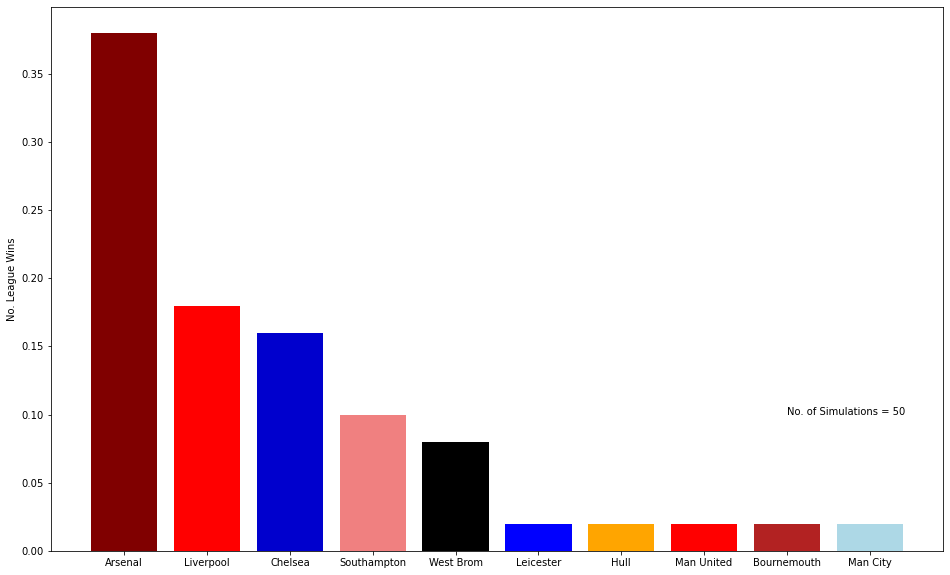

In [59]:
plt.figure(figsize=(16,10))
farben=['maroon','red','mediumblue','lightcoral','black','blue','orange','red','firebrick','lightblue']
plt.bar(x=pl_winners.index,height=pl_winners/N,color=farben)
plt.ylabel('No. League Wins')
plt.text(8,0.1,'No. of Simulations = %i'%(N))